In [1]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web

/usr/local/miniconda3/envs/master-thesis/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from stochastic_rnn import StochasticLSTM
from variational_module import MCDualOutputModule
from distribution_loss import GaussianLoss
from regression_uncertainty_utils import aleatoric_uncertainty, epistemic_uncertainty, prediction_avg, uncertainty
from train_utils import train_model

In [5]:
np.random.seed(1234)
torch.manual_seed(1234)

In [6]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17').astype(np.float32)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506096.0,52.296970
...,...,...,...,...,...,...
2019-12-11,271.100006,268.500000,268.809998,270.769989,19689200.0,270.128906
2019-12-12,272.559998,267.320007,267.779999,271.459991,34327600.0,270.817261
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,274.498535


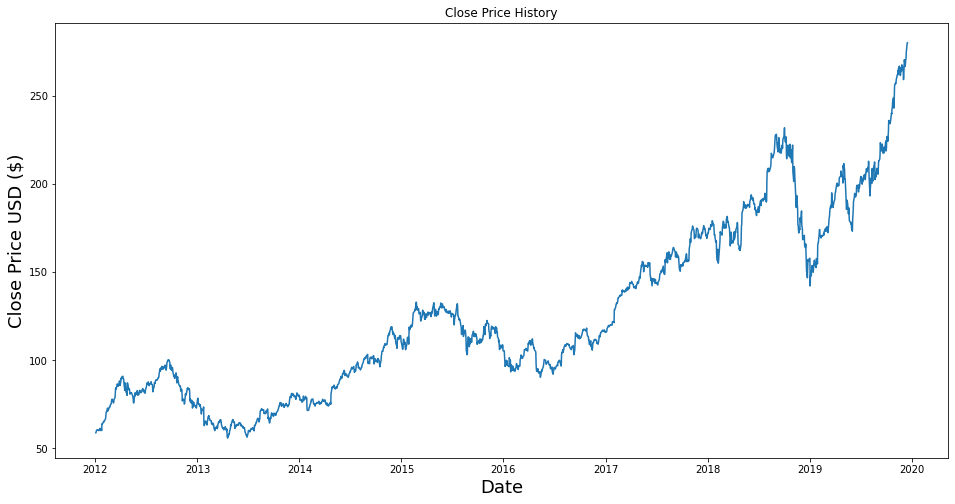

In [7]:
plt.figure(figsize=(16, 8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.show()

In [8]:
data = df.filter(["Close"])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1603

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457062],
       [0.01748985],
       ...,
       [0.97658265],
       [0.99755144],
       [1.0000001 ]], dtype=float32)

In [10]:
STEP = 60
ls = 1e-2
tau = 1

In [11]:
train_data = scaled_data[0:training_data_len, :]

x_train = np.array([train_data[i-STEP:i, 0] for i in range(STEP, training_data_len)])
y_train = np.array([train_data[i, 0] for i in range(STEP, training_data_len)])

In [12]:
ENTRY_COUNT = len(y_train)

In [13]:
x_train = x_train.reshape(ENTRY_COUNT, STEP, 1)
x_train.shape

(1543, 60, 1)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
traindl = torch.utils.data.DataLoader([(x_train[i], y_train[i]) for i in range(len(y_train))], shuffle=True, batch_size=50)
valdl = torch.utils.data.DataLoader([(x_val[i], y_val[i]) for i in range(len(y_val))], shuffle=True, batch_size=50)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = StochasticLSTM(1, 50)
        self.fc1 = nn.Linear(50, 25)
        self.fc2_mean = nn.Linear(25, 1)
        self.fc2_log_var = nn.Linear(25, 1)
    
    def regularizer(self):
        length_scale = ls
        precision = tau
        
        # Weight and bias regularizer
        weight_sum, bias_sum, dropout_reg = self.rnn.regularizer()
        
        return (weight_sum + bias_sum + dropout_reg) * 0.5 * length_scale**2 / precision
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = result[-1,:]
        result = self.fc1(result)
        mean = self.fc2_mean(result)
        log_var = self.fc2_log_var(result)
        return mean, log_var

In [16]:
net = Net()
criterion = GaussianLoss()

optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [17]:
net = train_model(net, traindl, valdl, criterion, optimizer, "stock-price-concrete.pt")

[1, 100.00%] train loss: -0.096158
[1, 100.00%] validate loss: -0.348910
[2, 100.00%] train loss: -0.827095
[2, 100.00%] validate loss: -1.506196
[3, 100.00%] train loss: -1.391865
[3, 100.00%] validate loss: -1.448727
Retry 1/5
[4, 100.00%] train loss: -1.455145
[4, 100.00%] validate loss: -1.483168
Retry 2/5
[5, 100.00%] train loss: -1.475656
[5, 100.00%] validate loss: -1.536182
[6, 100.00%] train loss: -1.497294
[6, 100.00%] validate loss: -1.564500
[7, 100.00%] train loss: -1.523358
[7, 100.00%] validate loss: -1.639215
[8, 100.00%] train loss: -1.521815
[8, 100.00%] validate loss: -1.723538
[9, 100.00%] train loss: -1.634360
[9, 100.00%] validate loss: -1.757693
[10, 100.00%] train loss: -1.747192
[10, 100.00%] validate loss: -1.950004
[11, 100.00%] train loss: -1.963848
[11, 100.00%] validate loss: -2.290669
[12, 100.00%] train loss: -2.224454
[12, 100.00%] validate loss: -2.353962
[13, 100.00%] train loss: -2.457655
[13, 100.00%] validate loss: -2.774228
[14, 100.00%] train los

In [18]:
print("Dropout rate = %.2f" % net.rnn.first_layer.p_logit.sigmoid().data.numpy())

Dropout rate = 0.39


In [19]:
sto_net = MCDualOutputModule(net)

In [20]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = torch.tensor([test_data[i-60:i, 0] for i in range(60, len(test_data))])
y_test = dataset[training_data_len:,:]
x_test = x_test.reshape(len(x_test), STEP, 1)

In [21]:
sto_net.eval()
with torch.no_grad():
    out_mean, out_log_var = sto_net(x_test.transpose(1, 0))
    A = aleatoric_uncertainty(out_log_var)
    E = epistemic_uncertainty(out_mean)
    uncertainties = uncertainty(out_mean, out_log_var)
    uncertainties = uncertainties.data.numpy()
    predictions = prediction_avg(out_mean)
    predictions = scaler.inverse_transform(predictions.data.numpy())

rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

5.9206305

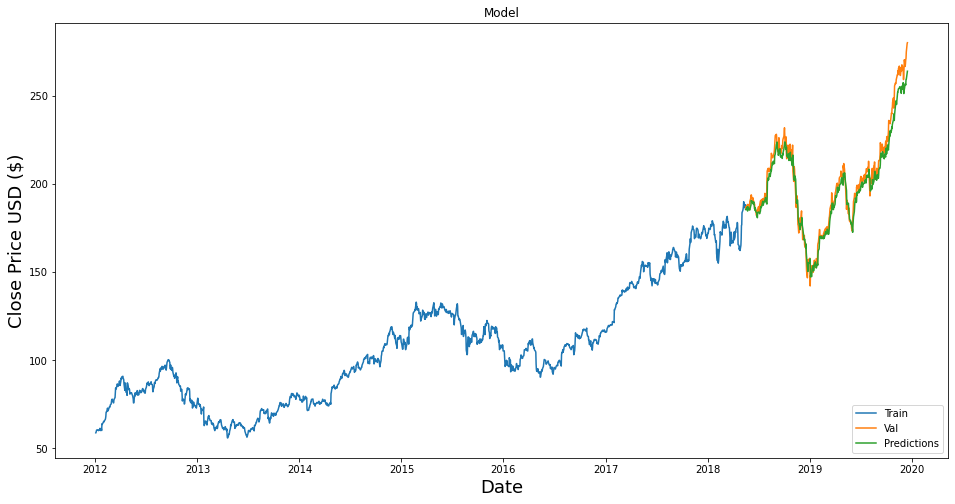

In [22]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid.insert(1,"Predictions",predictions)
valid.insert(2,"Uncertainties",uncertainties)

plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()